In [ ]:
import os

import pandas as pd 

from cleaning_utils import *

In [ ]:
directory = 'data/curated/'

patients_admissions = pd.read_parquet(directory + 'patients_admissions.parquet')

In [ ]:
patients_admissions.head(5)

## Check ICU data 

In [ ]:
raw_dir = 'data/raw/'
icu = pd.read_csv(raw_dir + 'ICUSTAYS.csv')
    

In [ ]:
## Clean ICU 
icu = standardise_col_names(icu)

In [ ]:
icu.head()

In [ ]:
## 1. Clean time cols 
time_cols = [col for col in icu.columns if col.endswith('time')]

for col in time_cols:
    icu[col] = pd.to_datetime(icu[col])
    print(f'new dtype: {icu[col].dtype}')

In [ ]:
icu.dbsource.value_counts()

DB Source: clinical information system (CIS) was used to record the patient’s ICU data.

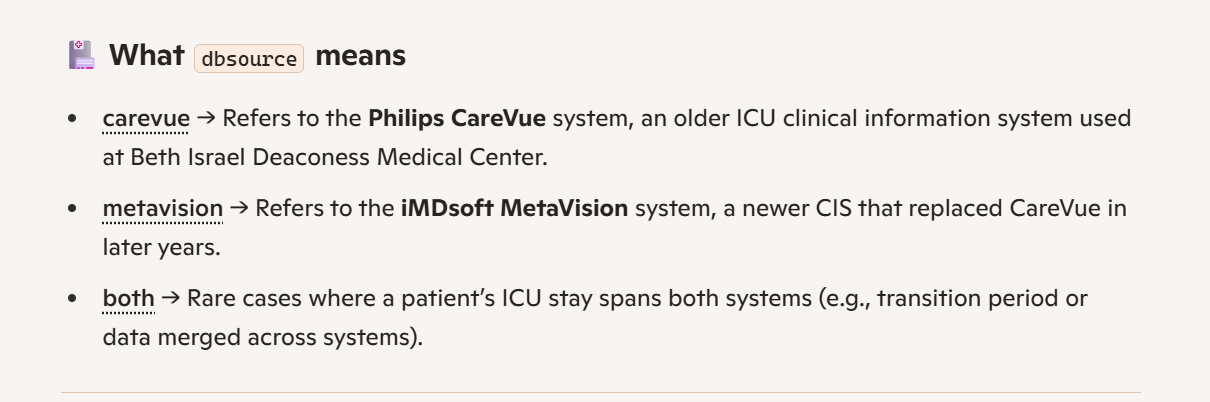

In [ ]:
## Compute comparison once 
correct_time_order = icu.outtime > icu.intime

## Sanity checks 
time_check = all(correct_time_order)
print(f'All rows have out time larger than in time? {time_check}')

## How many rows are wrong?
print((correct_time_order.value_counts() * 100/ icu.shape[0]))

## Further checks 
icu[~correct_time_order]

About .01% of the rows have inaccurate timings --> closer inspection revealed that the outtimes are all NaTs --> how to deal?

In [ ]:
## Clean LOS column name
icu_cleaned = icu.rename(columns = {'los':'los_icu_days'})

### Number of ICU stays per patient 

In [ ]:
icu.groupby('subject_id')['icustay_id'].count().value_counts().sort_index().head(10)

In [ ]:
## is there an anomaly? 
icu.groupby('subject_id')['icustay_id'].count().describe()

In [ ]:
## Who are the patients with very high icu counts?
top_10_icu_patients = icu.groupby('subject_id')['icustay_id'].count().sort_values(ascending = False).head(10).index
top_10_icu_patients

In [ ]:
icu[icu.subject_id.isin(top_10_icu_patients)].head()

In [ ]:
## For the number of icu in the same admission
icu.groupby('hadm_id')['icustay_id'].count().sort_values(ascending = False).head(10)

## Feature engineering: nth ICU per patient admission 

In [ ]:
icu['nth_visit_per_patient_admission'] = icu.groupby(['subject_id', 'hadm_id'])['intime'].rank(method = 'dense').astype(int)

## Check 
example_hadm_id = 163281
icu[icu.hadm_id == example_hadm_id].head()[['subject_id', 'hadm_id', 'icustay_id', 'intime', 'outtime', 'nth_visit_per_patient_admission']]

# Transformation

In [ ]:
print(icu.shape)
print(patients_admissions.shape)

### Basic sanity checks 

In [ ]:
all_admission_ids = set(patients_admissions.hadm_id.unique())
all_icu_admission_ids = set(icu.hadm_id.unique())
print(f'total number of admissions : {len(all_admission_ids)}')
print(f'total number of ICU admissions : {len(all_icu_admission_ids)}')

## How many admissions didnt result in ICUs?
print(len(all_admission_ids.difference(all_icu_admission_ids)))

## Which ICU admission is not in admissions table (sanity check)
print(len(all_icu_admission_ids.difference(all_admission_ids)))

### ICU left join patient admission --> ICU is the base table

In [ ]:
patients_admissions_icu = icu.merge(patients_admissions, on = ['subject_id', 'hadm_id'], how = 'left')

In [ ]:
## Second check 
print(patients_admissions_icu.shape)

In [ ]:
## Understand currrent dataset
pd.set_option('display.max_columns', None)

example_sub_id = 23657
patients_admissions_icu[(patients_admissions_icu.subject_id == example_sub_id) & 
                        (patients_admissions_icu.hadm_id == 125544)]

### Understanding the data

In this example, this patient (id = 23657) was admitted (id = 125544) from 18th Feb until 27th Feb for a total of 8 days and 21 hours. 

During this period, he/she was sent to the ICU twice: the first was from 19th Feb to 22th Feb for 3.2 days, and then from 24th Feb to 26th Feb. 

Timeline 
* 18th Feb: admitted
* 19th Feb: first ICU
* 22th Feb: out of first ICU
* 24th Feb: second ICU
* 26th Feb: out of second ICU
* 27th Feb: discharged 

The diagnosis for the admission was dehydration

In [ ]:
## Which disease causes the most icu visits?
patients_admissions_icu.groupby('diagnosis')['icustay_id'].count().sort_values(ascending = False).head(10)

### Feature engineering

In [ ]:
## Creating time-to-icu (if first ICU, then time from admission to ICU - otherwise, time from the latest ICU

## Init col 
patients_admissions_icu['time_to_icu'] = np.nan

## For first ICUs, find admission time to ICU
first_icu_mask = patients_admissions_icu.nth_visit_per_patient_admission == 1
patients_admissions_icu.loc[first_icu_mask, 'time_to_icu'] = patients_admissions_icu.loc[first_icu_mask, 'intime']\
                                                             - patients_admissions_icu.loc[first_icu_mask, 'admittime']

## For the rest, find time from the previous ICU 

## We first need get the lagged icu outtime 
## First sort 
patients_admissions_icu.sort_values(['subject_id', 'hadm_id', 'intime', 'outtime'])
## Now add the lagged icu outtime
patients_admissions_icu['lagged_icu_outtime'] = patients_admissions_icu.groupby(['subject_id', 'hadm_id'])['outtime'].shift(1)

## Sanity check 
example_hadm_id = 131118
patients_admissions_icu[patients_admissions_icu.hadm_id == example_hadm_id][['subject_id', 'hadm_id', 'intime'
                                                                             ,'outtime', 'lagged_icu_outtime','nth_visit_per_patient_admission']]
## Now, add time_to_icu for the rest of the rows 
patients_admissions_icu.loc[~first_icu_mask, 'time_to_icu'] = patients_admissions_icu.loc[first_icu_mask, 'intime']\
                                                             - patients_admissions_icu.loc[first_icu_mask, 'lagged_icu_outtime']


In [ ]:
## Check
pd.api.types.is_datetime64_any_dtype(patients_admissions_icu.lagged_icu_outtime)
pd.api.types.is_datetime64_any_dtype(patients_admissions_icu.intime)
# pd.api.types.is_datetime64_any_dtype(patients_admissions_icu.time_to_icu)
patients_admissions_icu.time_to_icu.dtype

In [ ]:
patients_admissions_icu[['intime', 'admittime']].dtypes

### Feature engineering: icu mortality 

In [ ]:
patients_admissions_icu['icu_mortality'] = (
    (patients_admissions_icu["DOD_consolidated"] >= patients_admissions_icu["intime"] - pd.Timedelta(hours=6)) &
    (patients_admissions_icu["DOD_consolidated"] <= patients_admissions_icu["outtime"] + pd.Timedelta(hours=6))
).astype(int)

## Check 
patients_admissions_icu.icu_mortality.value_counts()

## Some analysis

In [ ]:
pd.DataFrame(patients_admissions_icu.groupby('first_careunit')['icu_mortality'].mean().sort_values(ascending=False))

In [ ]:
## Save as transformed

# Save data

In [ ]:
patients_admissions_icu.to_parquet("data/curated/icu_patients_admissions.parquet")